In [47]:
# Import Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
from pathlib import Path
# import pandas_profiling
from category_encoders import *

sns.set_theme()


## 1. Download & Load Data 


In [3]:
DATA_PATH = Path('../data')

if 'data' not in os.listdir('..') or 'train.csv' not in os.listdir('../data'):
    print('downloading kaggle data')
    ! mkdir ../data
    ! kaggle competitions download -c titanic
    ! unzip titanic.zip
    ! mv *.csv ../data
    ! rm titanic.zip
    ! mkdir ../data/submissions
    ! mv ../data/*_submission* ../data/submissions/
else:
    print('kaggle data already downloaded in ../data')
    


kaggle data already downloaded in ../data


In [4]:
train = pd.read_csv(DATA_PATH / 'train.csv', index_col=0)
test = pd.read_csv(DATA_PATH / 'test.csv', index_col=0)

low_func = lambda x: x.lower()

train.columns = map(low_func, train.columns)
test.columns = map(low_func, test.columns)

print('train', train.shape)
print('test', test.shape)

train (891, 11)
test (418, 10)


**variable exploration**

pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## 2. Data Analysis & Cleansing

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    418 non-null    int64  
 1   name      418 non-null    object 
 2   sex       418 non-null    object 
 3   age       332 non-null    float64
 4   sibsp     418 non-null    int64  
 5   parch     418 non-null    int64  
 6   ticket    418 non-null    object 
 7   fare      417 non-null    float64
 8   cabin     91 non-null     object 
 9   embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


Immediately we see that cabin is a sparse column that has a lot of nulls. 

Age, Embarked & Fare also have null values to deal with

In [7]:
train.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot: >

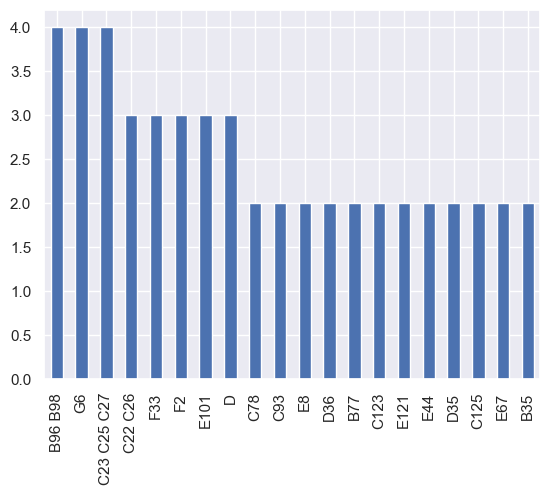

In [8]:
train.cabin.value_counts()[:20].plot.bar()

In [9]:
train.groupby('embarked').survived.mean()

embarked
C    0.553571
Q    0.389610
S    0.336957
Name: survived, dtype: float64

<AxesSubplot: xlabel='embarked', ylabel='Count'>

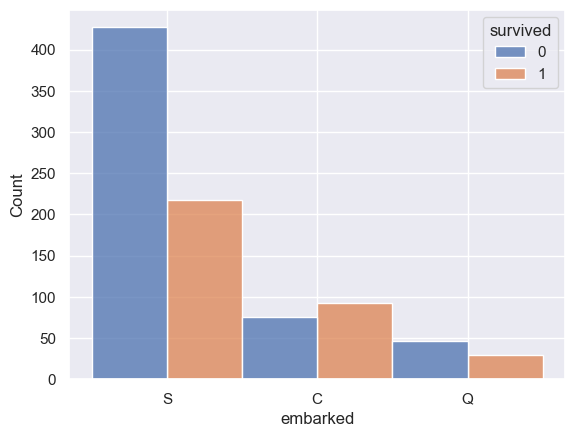

In [10]:
sns.histplot(train, x='embarked', hue='survived', multiple='dodge')

In [11]:
# most people embarked in Southampton so fill na values with an S (the modal value)
# interesting to note that a higher ratio of passengers from C survived

train_embarked_mode = train[~pd.isna(train.embarked)].embarked.mode()[0]

train['embarked'] = train.embarked.fillna(train_embarked_mode)
test['embarked'] = test.embarked.fillna(train_embarked_mode)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


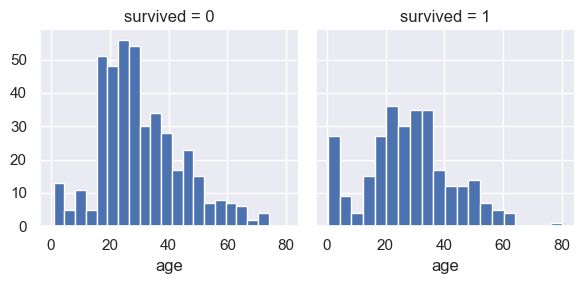

In [13]:
g = sns.FacetGrid(train, col='survived')
g.map(plt.hist, 'age', bins=20)

<AxesSubplot: xlabel='age', ylabel='Count'>

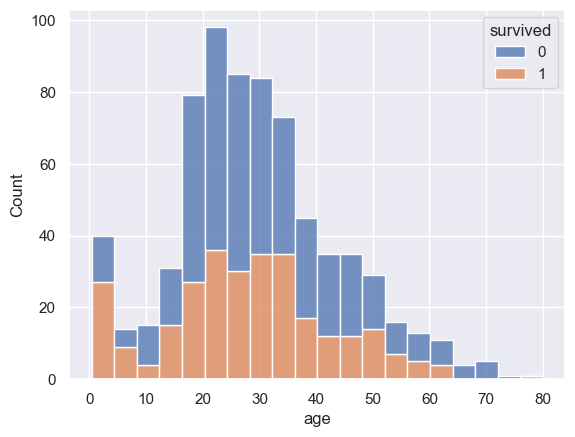

In [14]:
sns.histplot(train, x='age', hue='survived', multiple='stack')

In [15]:
print('Survival rates')
print(f'mean: {train.survived.mean():.2f}')
print(f'u8: {train[train.age < 8].survived.mean():.2f}')

Survival rates
mean: 0.38
u8: 0.68


It appears that children below 8 had a high survival rate, so age will be a strong factor

### Investigate Relationship between Gender and Survival

In [16]:
train.groupby('sex').survived.mean()

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

<AxesSubplot: xlabel='age', ylabel='Count'>

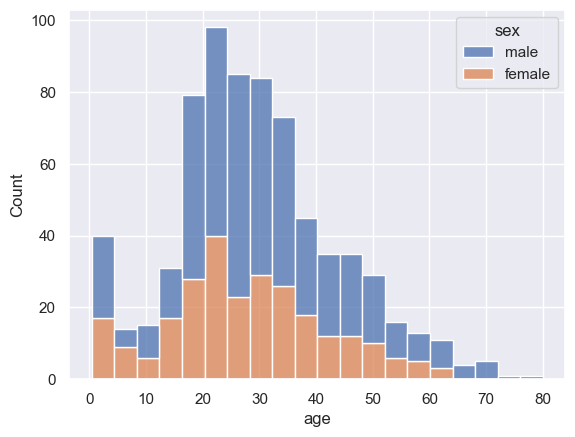

In [17]:
sns.histplot(train, x='age', hue='sex', multiple='stack')

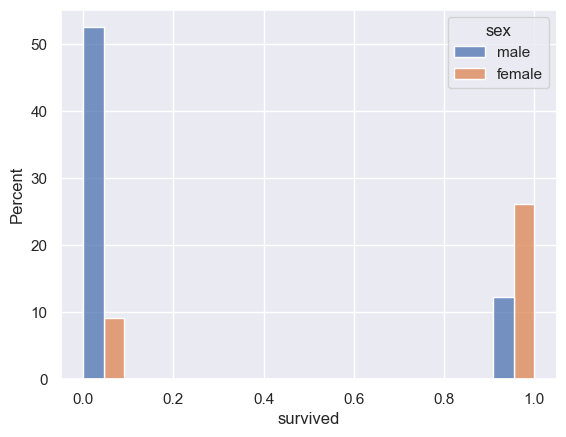

In [18]:
g = sns.histplot(train, x='survived', hue='sex', multiple='dodge', stat='percent')
plt.show()

In [19]:
train.name.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: name, Length: 891, dtype: int64

Names are unique (count=891)

### Investigate Passenger Class

<AxesSubplot: xlabel='age', ylabel='Count'>

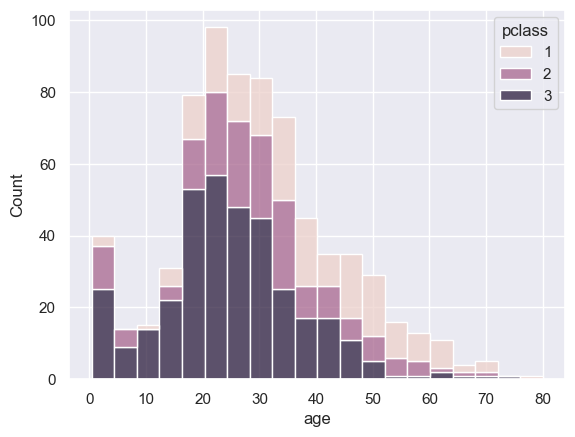

In [20]:
sns.histplot(train, x='age', hue='pclass', multiple='stack')

In [21]:
train.groupby('pclass').age.mean()

pclass
1    38.233441
2    29.877630
3    25.140620
Name: age, dtype: float64

In [22]:
train.groupby('pclass').survived.mean()

pclass
1    0.629630
2    0.472826
3    0.242363
Name: survived, dtype: float64

Passengers in first class were on average older

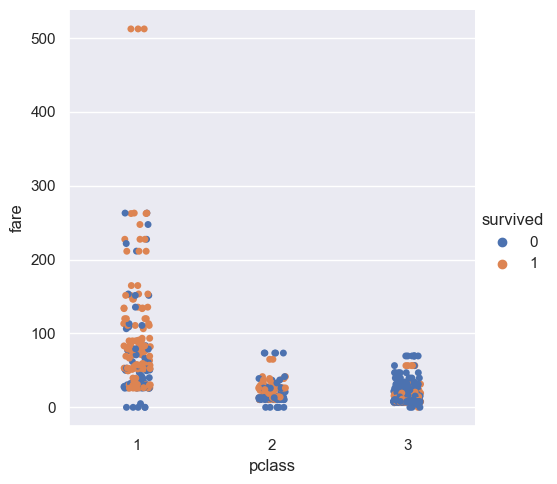

In [23]:
sns.catplot(train, x='pclass', y='fare', hue='survived')

<AxesSubplot: xlabel='age', ylabel='fare'>

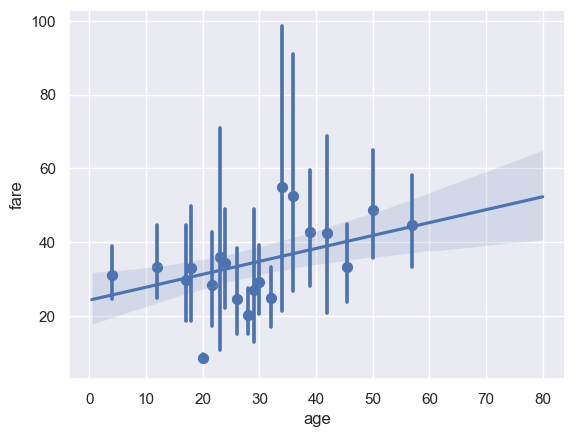

In [24]:
sns.regplot(train, x='age', y='fare', x_bins=20)

<AxesSubplot: xlabel='pclass', ylabel='fare'>

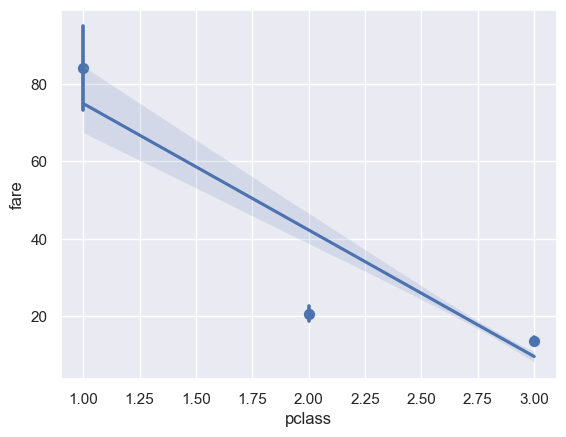

In [25]:
sns.regplot(train, x='pclass', y='fare', x_bins=20)

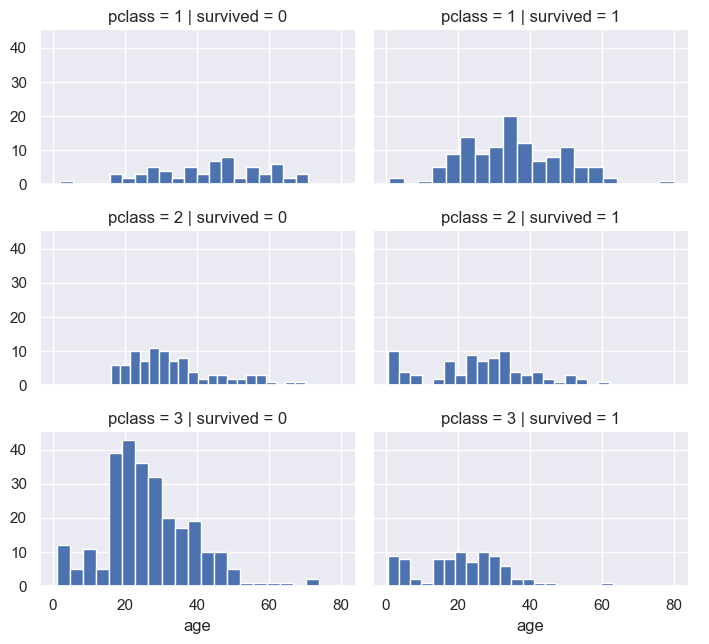

In [26]:
grid = sns.FacetGrid(train, col='survived', row='pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', bins=20)
grid.add_legend();

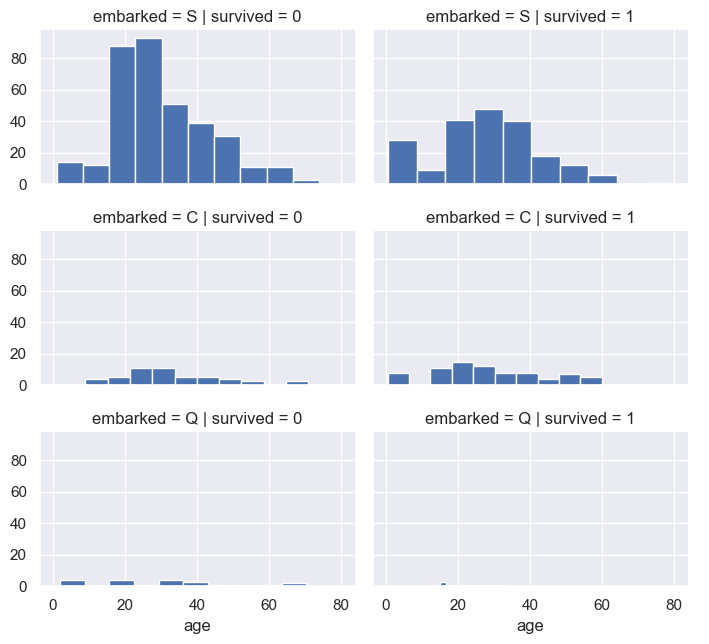

In [27]:
grid = sns.FacetGrid(train, col='survived', row='embarked', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age')
grid.add_legend();

### Investigate Family Size

In [28]:
train.groupby('sibsp').survived.mean()

sibsp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: survived, dtype: float64

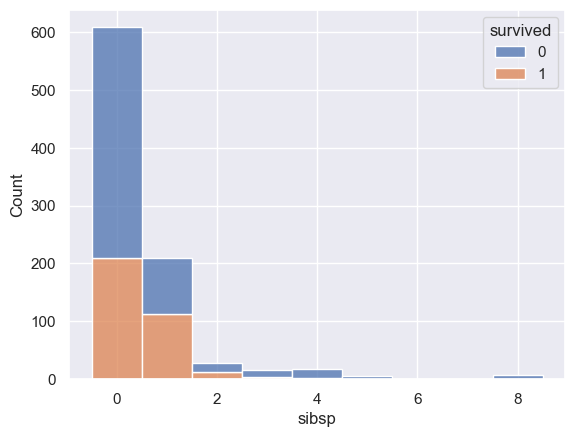

sibsp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: survived, dtype: float64

In [29]:
sns.histplot(train, x='sibsp', hue='survived', multiple='stack', discrete=True)
plt.show()
train.groupby('sibsp').survived.mean()

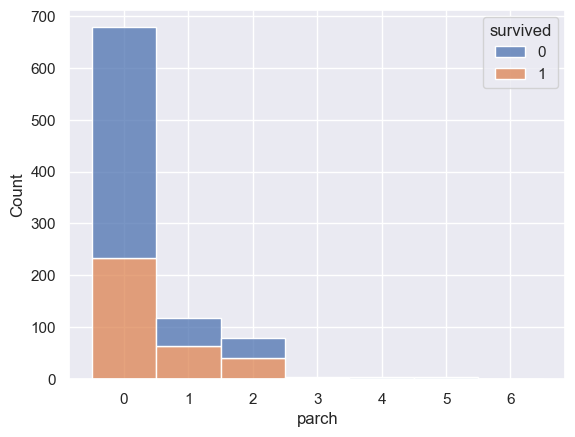

parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: survived, dtype: float64

In [30]:
sns.histplot(train, x='parch', hue='survived', multiple='stack', discrete=True)
plt.show()
train.groupby('parch').survived.mean()

 
### Fill in missing values for age and fare



In [31]:
median_age_by_sex_pclass = train[~pd.isna(train.age)].groupby(['sex', 'pclass']).age.median().rename('median_age')
median_age_by_sex_pclass

sex     pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: median_age, dtype: float64

In [32]:
# fill in NA ages with the median age of people with the same sex and pclass 
#   - Sex & pclass used due to low dimensionality and correlation with age
train['age'] = (
    train['age'].fillna(
        train.merge(median_age_by_sex_pclass, how='left', 
                    left_on=['sex', 'pclass'], right_index=True)['median_age']
    )
)
test['age'] = (
    test['age'].fillna(
        test.merge(median_age_by_sex_pclass, how='left', 
                    left_on=['sex', 'pclass'], right_index=True)['median_age']
    )
)

In [33]:
assert sum(pd.isna(test.age)) == 0 and sum(pd.isna(train.age)) == 0

In [34]:
median_fare_by_pclass = train[~pd.isna(train.fare)].groupby('pclass').fare.median().rename('median_fare')
median_fare_by_pclass

pclass
1    60.2875
2    14.2500
3     8.0500
Name: median_fare, dtype: float64

In [35]:
# fill in NA fares with the median fare of people with the same pclass 

train['fare'] = (
    train['fare'].fillna(
        train.merge(median_fare_by_pclass, how='left', 
                    left_on='pclass', right_index=True)['median_fare']
    )
)
test['fare'] = (
    test['fare'].fillna(
        test.merge(median_fare_by_pclass, how='left', 
                    left_on='pclass', right_index=True)['median_fare']
    )
)

In [36]:
assert sum(pd.isna(test.fare)) == 0 and sum(pd.isna(train.fare)) == 0

## 3. Feature Engineering

In [37]:
# drop the cabin and ticket columns as they are mostly noise
train = train.drop(columns=['cabin', 'ticket'])
test = test.drop(columns=['cabin', 'ticket'])

train.shape, test.shape

((891, 9), (418, 8))

In [38]:
train.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
PassengerId,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


### Convert categorical features to numeric

In [42]:
train.groupby('embarked').survived.mean()

embarked
0.339009    0.339009
0.389591    0.389610
0.553571    0.553571
Name: survived, dtype: float64

In [43]:
encoder = TargetEncoder()
train['embarked'] = encoder.fit_transform(train.embarked, train.survived)
test['embarked'] = encoder.transform(test.embarked)

In [45]:
gender_categories = {
    'male': 0, 
    'female': 1
}

train['sex'] = train.sex.map(gender_categories)
test['sex'] = test.sex.map(gender_categories)

In [46]:
train.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
PassengerId,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0.339009
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,0.553571
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0.339009
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,0.339009
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0.339009


### Create column 'title' from the name column

In [57]:
string = "I am Mr. Jones"
match = re.findall(r"\w+\. ", string)
print(match)



['Mr. ']


In [48]:
train.name.apply(lambda x: re.search('\r\w+\.', x)[0])

TypeError: 'NoneType' object is not subscriptable